# Yin Algorithm
Re-implementing the Yin algorithm as a baseline, and returning all valid harmonic matches. With the hope that we can optimize it for violin/music performance. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from os import sep
import time

In [4]:
def difference_func(x: np.ndarray, tau_max: int) -> np.ndarray:
    """
    Fast difference function implementation using numpy's FFT.
    Step 1 of Yin algorithm, corresponding to equation (6) in Cheveigne, Kawahara 2002.
    Adopted from https://github.com/patriceguyot/Yin

    Args:
        x: audio data
        tau_max: integration window size.

    Returns: 
        diff: An array of size tau_max with the difference function values.
    """

    x = np.array(x, np.float64) # Ensure float64 precision
    w = x.size
    tau_max = min(tau_max, w)
    size = w + tau_max

    # Cumulative sum of squares of each sample in the signal
    x_cumsum = np.concatenate((np.array([0.]), (x*x).cumsum()))
    
    # List of numbers when multiplied by 2^p2 are greater than size
    # (for efficient fft computation?..)
    p2 = (size // 32).bit_length()
    nice_numbers = (16, 18, 20, 24, 25, 27, 30, 32)
    size_pad = min(x * 2**p2 for x in nice_numbers if x * 2**p2 >= size)

    # Q1: How does rfft, fft, and irfft work? and conjugate?
    # Q2: Why is it called 'fc' and 'conv'?
    fc = np.fft.rfft(x, size_pad)
    conv = np.fft.irfft(fc * fc.conjugate())[:tau_max]
    diff = x_cumsum[w:w - tau_max:-1] + x_cumsum[w] - x_cumsum[:tau_max] - 2*conv

    return diff

In [12]:
def cumulativeMeanNormalizedDifferenceFunction(df, N):
    """
    Compute cumulative mean normalized difference function (CMND).

    This corresponds to equation (8) in [1]

    :param df: Difference function
    :param N: length of data
    :return: cumulative mean normalized difference function
    :rtype: list
    """

    cmndf = df[1:] * range(1, N) / np.cumsum(df[1:]).astype(float) #scipy method
    return np.insert(cmndf, 0, 1)

In [ ]:
import librosa

AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'  
audio_data, sr = librosa.load(AUDIO_FILEPATH, sr=None)

# Define violin frequency range
MIN_VIOLIN_FREQ = 196  # Hz
MAX_VIOLIN_FREQ = 5000  # Hz

sample = audio_data[:1028]
tau_max = int(sr / 500) # why do they define tau_max as such?

diff_sample = difference_func(sample, 500)
cmdf = cumulativeMeanNormalizedDifferenceFunction(diff_sample, tau_max)

# Plot the difference function
plt.figure(figsize=(10, 6))
plt.plot(cmdf, label='(cm) Difference Function')
plt.title('Difference Function of Audio Sample')
plt.xlabel('Lag (samples)')
plt.ylabel('Difference Function Value')
plt.grid(True)
plt.legend()
plt.show()

Yin: compute yin algorithm
Yin computed in:  0.34390783309936523


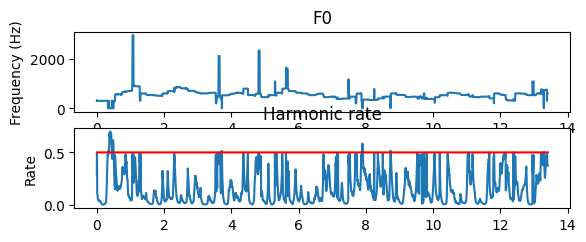

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from os import sep
import librosa
import time

def differenceFunction(x, N, tau_max):
    """
    Compute difference function of data x. This corresponds to equation (6) in [1]

    Fastest implementation. Use the same approach than differenceFunction_scipy.
    This solution is implemented directly with Numpy fft.


    :param x: audio data
    :param N: length of data
    :param tau_max: integration window size
    :return: difference function
    :rtype: list
    """

    x = np.array(x, np.float64)
    w = x.size
    tau_max = min(tau_max, w)
    x_cumsum = np.concatenate((np.array([0.]), (x * x).cumsum()))
    size = w + tau_max
    p2 = (size // 32).bit_length()
    nice_numbers = (16, 18, 20, 24, 25, 27, 30, 32)
    size_pad = min(x * 2 ** p2 for x in nice_numbers if x * 2 ** p2 >= size)
    fc = np.fft.rfft(x, size_pad)
    conv = np.fft.irfft(fc * fc.conjugate())[:tau_max]
    return x_cumsum[w:w - tau_max:-1] + x_cumsum[w] - x_cumsum[:tau_max] - 2 * conv



def cumulativeMeanNormalizedDifferenceFunction(df, N):
    """
    Compute cumulative mean normalized difference function (CMND).

    This corresponds to equation (8) in [1]

    :param df: Difference function
    :param N: length of data
    :return: cumulative mean normalized difference function
    :rtype: list
    """

    cmndf = df[1:] * range(1, N) / np.cumsum(df[1:]).astype(float) #scipy method
    return np.insert(cmndf, 0, 1)



def getPitch(cmdf, tau_min, tau_max, harmo_th=0.1):
    """
    Return fundamental period of a frame based on CMND function.

    :param cmdf: Cumulative Mean Normalized Difference function
    :param tau_min: minimum period for speech
    :param tau_max: maximum period for speech
    :param harmo_th: harmonicity threshold to determine if it is necessary to compute pitch frequency
    :return: fundamental period if there is values under threshold, 0 otherwise
    :rtype: float
    """
    tau = tau_min
    while tau < tau_max:
        if cmdf[tau] < harmo_th:
            while tau + 1 < tau_max and cmdf[tau + 1] < cmdf[tau]:
                tau += 1
            return tau
        tau += 1

    return 0    # if unvoiced



def compute_yin(sig, sr, dataFileName=None, w_len=512, w_step=256, f0_min=100, f0_max=500, harmo_thresh=0.1):
    """

    Compute the Yin Algorithm. Return fundamental frequency and harmonic rate.

    :param sig: Audio signal (list of float)
    :param sr: sampling rate (int)
    :param w_len: size of the analysis window (samples)
    :param w_step: size of the lag between two consecutives windows (samples)
    :param f0_min: Minimum fundamental frequency that can be detected (hertz)
    :param f0_max: Maximum fundamental frequency that can be detected (hertz)
    :param harmo_tresh: Threshold of detection. The yalgorithmù return the first minimum of the CMND fubction below this treshold.

    :returns:

        * pitches: list of fundamental frequencies,
        * harmonic_rates: list of harmonic rate values for each fundamental frequency value (= confidence value)
        * argmins: minimums of the Cumulative Mean Normalized DifferenceFunction
        * times: list of time of each estimation
    :rtype: tuple
    """

    print('Yin: compute yin algorithm')
    tau_min = int(sr / f0_max)
    tau_max = int(sr / f0_min)

    timeScale = range(0, len(sig) - w_len, w_step)  # time values for each analysis window
    times = [t/float(sr) for t in timeScale]
    frames = [sig[t:t + w_len] for t in timeScale]

    pitches = [0.0] * len(timeScale)
    harmonic_rates = [0.0] * len(timeScale)
    argmins = [0.0] * len(timeScale)

    for i, frame in enumerate(frames):

        #Compute YIN
        df = difference_func(frame, tau_max)
        cmdf = cumulativeMeanNormalizedDifferenceFunction(df, tau_max)
        p = getPitch(cmdf, tau_min, tau_max, harmo_thresh)

        #Get results
        if np.argmin(cmdf)>tau_min:
            argmins[i] = float(sr / np.argmin(cmdf))
        if p != 0: # A pitch was found
            pitches[i] = float(sr / p)
            harmonic_rates[i] = cmdf[p]
        else: # No pitch, but we compute a value of the harmonic rate
            harmonic_rates[i] = min(cmdf)


    if dataFileName is not None:
        np.savez(dataFileName, times=times, sr=sr, w_len=w_len, w_step=w_step, f0_min=f0_min, f0_max=f0_max, harmo_thresh=harmo_thresh, pitches=pitches, harmonic_rates=harmonic_rates, argmins=argmins)
        print('\t- Data file written in: ' + dataFileName)

    return pitches, harmonic_rates, argmins, times


def main(audioFileName="whereIam.wav", w_len=1024, w_step=256, f0_min=70, f0_max=200, harmo_thresh=0.85, audioDir="./", dataFileName=None, verbose=4):
    """
    Run the computation of the Yin algorithm on a example file.

    Write the results (pitches, harmonic rates, parameters ) in a numpy file.

    :param audioFileName: name of the audio file
    :type audioFileName: str
    :param w_len: length of the window
    :type wLen: int
    :param wStep: length of the "hop" size
    :type wStep: int
    :param f0_min: minimum f0 in Hertz
    :type f0_min: float
    :param f0_max: maximum f0 in Hertz
    :type f0_max: float
    :param harmo_thresh: harmonic threshold
    :type harmo_thresh: float
    :param audioDir: path of the directory containing the audio file
    :type audioDir: str
    :param dataFileName: file name to output results
    :type dataFileName: str
    :param verbose: Outputs on the console : 0-> nothing, 1-> warning, 2 -> info, 3-> debug(all info), 4 -> plot + all info
    :type verbose: int
    """

    sig, sr = librosa.load(audioFileName, sr=None)

    start = time.time()
    pitches, harmonic_rates, argmins, times = compute_yin(sig, sr, dataFileName, w_len, w_step, f0_min, f0_max, harmo_thresh)
    end = time.time()
    print("Yin computed in: ", end - start)

    duration = len(sig)/float(sr)

    if verbose > 3:
        # ax1 = plt.subplot(4, 1, 1)
        # ax1.plot([float(x) * duration / len(sig) for x in range(0, len(sig))], sig)
        # ax1.set_title('Audio data')
        # ax1.set_ylabel('Amplitude')

        ax2 = plt.subplot(4, 1, 2)
        ax2.plot([float(x) * duration / len(pitches) for x in range(0, len(pitches))], pitches)
        ax2.set_title('F0')
        ax2.set_ylabel('Frequency (Hz)')

        ax3 = plt.subplot(4, 1, 3, sharex=ax2)
        ax3.plot([float(x) * duration / len(harmonic_rates) for x in range(0, len(harmonic_rates))], harmonic_rates)
        ax3.plot([float(x) * duration / len(harmonic_rates) for x in range(0, len(harmonic_rates))], [harmo_thresh] * len(harmonic_rates), 'r')
        ax3.set_title('Harmonic rate')
        ax3.set_ylabel('Rate')

        # ax4 = plt.subplot(4, 1, 4, sharex=ax2)
        # ax4.plot([float(x) * duration / len(argmins) for x in range(0, len(argmins))], argmins)
        # ax4.set_title('Index of minimums of CMND')
        # ax4.set_ylabel('Frequency (Hz)')
        # ax4.set_xlabel('Time (seconds)')
        
        plt.show()


AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'  
main(audioFileName=AUDIO_FILEPATH, w_len=2048, w_step=128, f0_min=196, f0_max=5000, harmo_thresh=0.5, audioDir="./", dataFileName=None, verbose=4)

Computing pitches...
Done! Took 0.43 seconds.


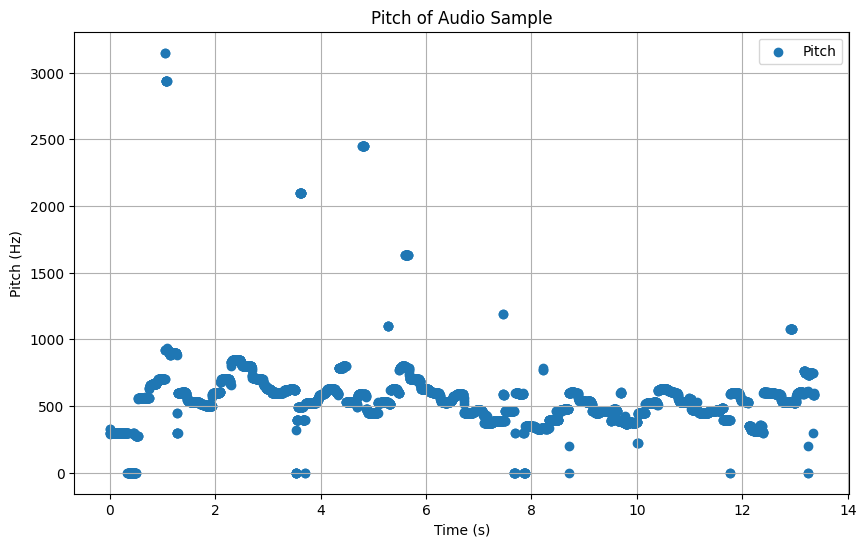

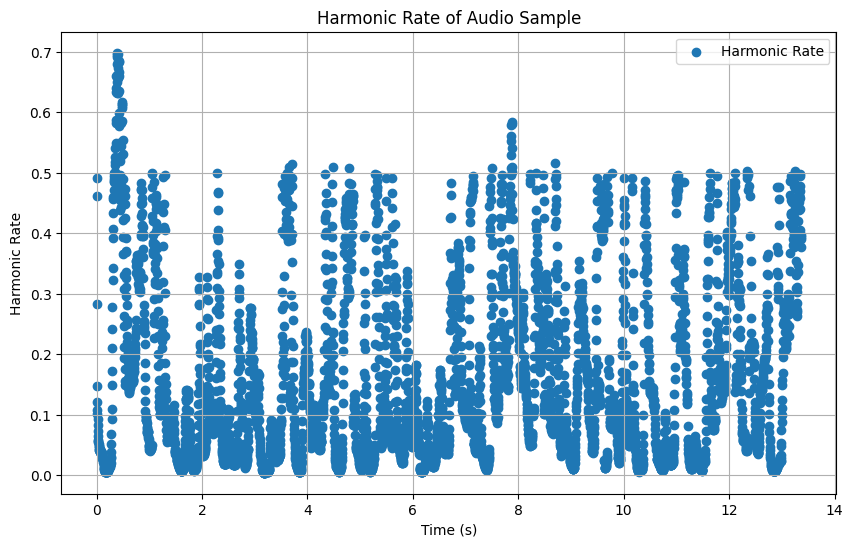

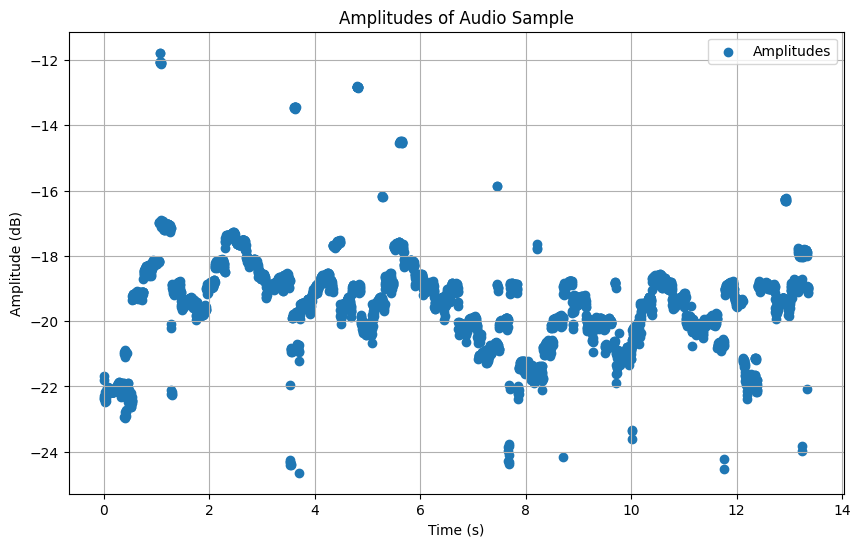

In [44]:
import sys
sys.path.append('..')

from app.modules.pitch.Yin import pitch_yin
import librosa

AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'

audio_data, sr = librosa.load(AUDIO_FILEPATH, sr=None)
pitches, harmonic_rates, amplitudes, argmins, times = pitch_yin(
    audio_data, sr, 
    frame_size=2048, hop_size=128, 
    min_freq=196, max_freq=5000, 
    max_diff=0.5
)

# Plot the pitches, harmonic rates, and argmins
# Flattening the list of lists
# flattened_pitches = [pitch for sublist in pitches for pitch in sublist]
# flattened_times = [times[i] for i in range(len(times)) for _ in pitches[i]]

# flattened_harmonic_rates = [rate for sublist in harmonic_rates for rate in sublist]
# flattened_amplitudes = [amp for sublist in amplitudes for amp in sublist]

# Plot the flattened pitches
plt.figure(figsize=(10, 6))
plt.scatter(times, pitches, label='Pitch')
plt.title('Pitch of Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.grid(True)
plt.legend()
plt.show()

# Plot the flattened harmonic rates
plt.figure(figsize=(10, 6))
plt.scatter(times, harmonic_rates, label='Harmonic Rate')
plt.title('Harmonic Rate of Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('Harmonic Rate')
plt.grid(True)
plt.legend()
plt.show()

# Plot the flattened amplitudes
plt.figure(figsize=(10, 6))
plt.scatter(times, amplitudes, label='Amplitudes')
plt.title('Amplitudes of Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (dB)')
plt.grid(True)
plt.legend()
plt.show()



Computing pitches...
Done! Took 0.51 seconds.
Segmenting notes...


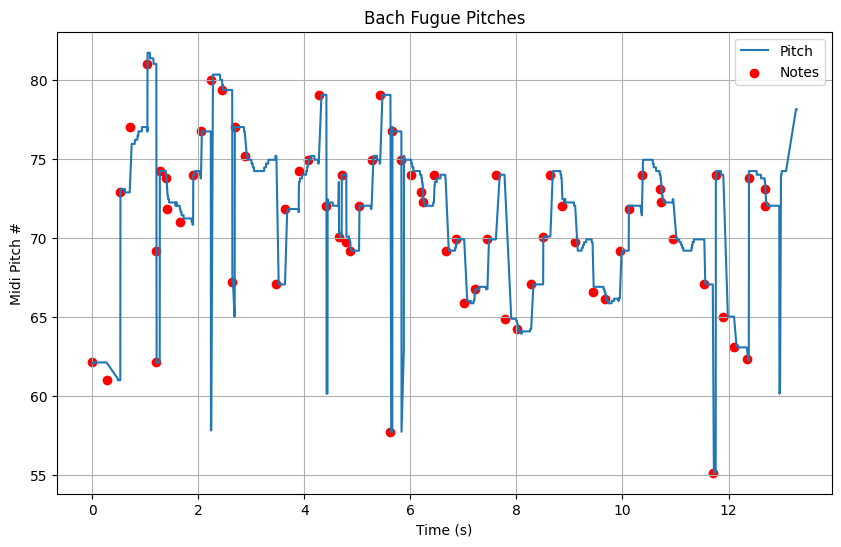

In [26]:
from app.modules.pitch.PitchAnalyzer import PitchAnalyzer
from app.modules.audio.AudioData import AudioData

AUDIO_FILEPATH = 'notebooks/data/audio_files/user_fugue2.mp3'
audio_data = AudioData()
audio_data.load_data('user_fugue2.mp3')

pitch_analyzer = PitchAnalyzer()
pitch_df = pitch_analyzer.user_pitchdf(audio_data)
note_df = pitch_analyzer.note_segmentation(pitch_df, window_size=11, threshold=0.4)

# Plot the pitch dataframe
plt.figure(figsize=(10, 6))
plt.plot(pitch_df['time'], pitch_df['midi_pitch'], label='Pitch')
plt.scatter(note_df['time'], note_df['midi_pitch'], color='red', label='Notes')

plt.title('Bach Fugue Pitches')
plt.xlabel('Time (s)')
plt.ylabel('Midi Pitch #')
plt.grid(True)
plt.legend()

In [41]:
pitch_df

,time,frequency,midi_pitch,confidence
0,0.000000,294.000000,62.019752,0.088694
1,0.002902,294.000000,62.019752,0.079094
2,0.005805,294.000000,62.019752,0.070567
3,0.008707,294.000000,62.019752,0.064139
4,0.011610,295.973154,62.135554,0.058831
...,...,...,...,...
4573,13.273107,747.457627,78.173859,0.298853
4574,13.276009,747.457627,78.173859,0.299037
4575,13.278912,747.457627,78.173859,0.290961
4576,13.281814,747.457627,78.173859,0.295260


In [42]:
for plist in pitches:
    print(plist)

[294.0]
[294.0]
[294.0]
[294.0]
[294.0]
[294.0]
[294.0]
[294.0]
[295.9731543624161]
[295.9731543624161]
[294.0]
[295.9731543624161]
[295.9731543624161]
[294.0]
[295.9731543624161]
[295.9731543624161]
[294.0]
[294.0]
[295.9731543624161]
[295.9731543624161]
[294.0]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.9731543624161]
[295.97315436241